# Análisis de Segmentación de Usuarios en la Aplicación Móvil Trash to Treasure

## Introducción

En el entorno actual de aplicaciones móviles, comprender el comportamiento de los usuarios es crucial para el éxito y la optimización del producto. Este proyecto se centra en el análisis de los datos de eventos generados por los usuarios de la aplicación móvil Trash to Treasure, una plataforma donde los usuarios pueden publicar anuncios para vender artículos que ya no necesitan.

El objetivo principal de este análisis es segmentar a los usuarios en función de su comportamiento en la aplicación y probar hipótesis estadísticas relacionadas con métricas clave del producto. Esta segmentación nos permitirá identificar grupos de usuarios con comportamientos similares, lo que a su vez ayudará a personalizar estrategias de marketing y mejorar la retención de usuarios.

**Objetivo del Proyecto**

El objetivo de este proyecto es segmentar a los usuarios y usuarias de la aplicación móvil Trash to Treasure en función de su comportamiento y analizar diferentes métricas del producto, como la tasa de retención, tiempo dedicado a la aplicación, frecuencia de eventos y conversión en el evento `contacts_show`.

**Pasos del Proyecto**

1. Importación de Librerías y Carga de Datos

- Importar las librerías necesarias.
- Cargar los datasets `mobile_dataset_us.csv` y `mobile_sources_us.csv`.

2. Preprocesamiento de Datos

- Revisar y manejar valores ausentes.
- Convertir tipos de datos si es necesario.
- Unificar el formato de los datos temporales.
- Fusionar datasets en función del `user.id`.

3. Análisis Exploratorio de Datos (EDA)

- Visualizar la distribución de eventos por tipo de evento.
- Analizar la distribución temporal de los eventos.
- Calcular y visualizar el número de usuarios por fuente de descarga.
- Analizar las frecuencias de los eventos por usuario.

4. Segmentación de Usuarios

- Definir criterios de segmentación basados en los eventos completados.
- Implementar técnicas de segmentación (e.g., clustering).
- Describir los segmentos resultantes en términos de métricas del producto.

5. Prueba de Hipótesis

- Formular y probar una hipótesis sobre la diferencia en la conversión en vistas de información de contacto entre quienes descargaron la aplicación de Bing y quienes la descargaron de Google.
- Formular una hipótesis estadística adicional sobre los datos del dataset y probarla.

6. Análisis de Métricas de Negocio

- Calcular y analizar la tasa de retención de usuarios.
- Calcular el tiempo promedio dedicado a la aplicación.
- Evaluar la frecuencia de ocurrencia de eventos.
- Analizar la conversión en el evento `contacts_show`.

7. Preparar una Presentación

- Crear visualizaciones claras y concisas de los hallazgos.
- Elaborar una narrativa que explique los resultados y su relevancia.
- Preparar un documento en PDF con la presentación final.

8. Tareas Adicionales (Opcional)

- Construir un cuadro de mando en Tableau para visualizar las métricas y los segmentos de usuarios.


### Descripción de los Datos

Este proyecto utilizará dos datasets principales:

1. **Eventos de la Aplicación (`mobile_dataset_us.csv`)**:
   - `event.time`: Fecha y hora del evento.
   - `event.name`: Tipo de evento (e.g., `advert_open`, `photos_show`, `contacts_show`).
   - `user.id`: Identificador único del usuario.

2. **Fuentes de Descarga (`mobile_sources_us.csv`)**:
   - `userId`: Identificador único del usuario.
   - `source`: Fuente desde la cual el usuario descargó la aplicación (e.g., Google, Bing, otros).

Este análisis permitirá una comprensión profunda del comportamiento de los usuarios en la aplicación, lo que a su vez ayudará a tomar decisiones informadas para mejorar la experiencia del usuario y optimizar las estrategias de marketing.

### Enlace a presentación 
https://drive.google.com/file/d/1e8Yq6LtcXcbr4PPh2TY0V7GJ7U7x00ak/view?usp=sharing


### Importación de librerias

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para clustering y preprocesamiento
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Librerías para pruebas estadísticas
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest


### Cargar Datos

In [2]:
# Función para cargar los datasets y proporcionar una descripción inicial
def cargar_datasets(paths):
    datasets = {}
    for name, path in paths.items():
        datasets[name] = pd.read_csv(path)
        print(f"\n{'-'*50}\n{name}:")
        display(datasets[name].head())
    return datasets

# Rutas de los archivos
paths = {
    "events": '/datasets/mobile_dataset_us.csv',
    "sources": '/datasets/mobile_sources_us.csv'
}

# Cargar los datasets
datasets = cargar_datasets(paths)

# Asignar los datasets cargados a variables individuales
events_df = datasets['events']
sources_df = datasets['sources']


--------------------------------------------------
events:


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c



--------------------------------------------------
sources:


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,bing
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,bing
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


El dataset `events` contiene información detallada sobre los eventos que ocurrieron en la aplicación móvil Trash to Treasure. Cada registro en el dataset representa un evento específico, identificado por tres campos principales: `event.time`, `event.name` y `user.id`. La columna `event.time` indica la fecha y hora exacta en que ocurrió el evento, lo que nos permitirá analizar patrones temporales en el comportamiento de los usuarios. La columna `event.name` especifica el tipo de evento realizado, como abrir una publicación publicitaria (`advert_open`) o ver anuncios recomendados (`tips_show`). La columna `user.id` es un identificador único que permite rastrear las acciones de cada usuario individualmente. Este dataset es fundamental para entender qué acciones realizan los usuarios dentro de la aplicación y con qué frecuencia.

El dataset `sources` proporciona información sobre la fuente desde la cual los usuarios descargaron la aplicación. Incluye dos campos principales: `userId` y `source`. La columna `userId` es un identificador único para cada usuario, que se puede relacionar con la columna `user.id` en el dataset `events` para integrar ambas fuentes de datos. La columna `source` indica la plataforma desde la cual el usuario descargó la aplicación, como Google, Bing, u otras fuentes no especificadas (`other`). Esta información es crucial para evaluar la efectividad de diferentes canales de adquisición de usuarios y para segmentar a los usuarios según su fuente de origen.



## Preparación de datos
Análisis Inicial de los Datos

In [3]:
# Función para análisis inicial de los datasets
def initial_data_analysis(data, name):
    print(f"\n{'='*50}\nAnálisis inicial del dataset: {name}\n{'='*50}")
    print(f"Tamaño del dataset: {data.shape}")
    print("Información del dataset:")
    data.info()
    print(f"\nValores nulos en cada columna:\n{data.isnull().sum()}")
    print(f"Número de filas duplicadas: {data.duplicated().sum()}")
    print("="*50 + "\n")

# Análisis inicial de los datasets
initial_data_analysis(events_df, "Events")
initial_data_analysis(sources_df, "Sources")



Análisis inicial del dataset: Events
Tamaño del dataset: (74197, 3)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB

Valores nulos en cada columna:
event.time    0
event.name    0
user.id       0
dtype: int64
Número de filas duplicadas: 0


Análisis inicial del dataset: Sources
Tamaño del dataset: (4293, 2)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB

Valores nulos en cada columna:
userId    0
sourc

El dataset `events` contiene 74,197 filas y 3 columnas. Las columnas son `event.time`, `event.name` y `user.id`, todas de tipo `object`. No hay valores nulos en ninguna de las columnas y tampoco hay filas duplicadas. Esto indica que los datos de eventos están completos y no presentan valores nulos ni duplicados, lo cual es una buena señal para proceder con el análisis sin necesidad de limpieza adicional en este aspecto.

El dataset `sources` contiene 4,293 filas y 2 columnas. Las columnas son `userId` y `source`, ambas de tipo `object`. Al igual que el dataset `events`, no hay valores nulos en ninguna de las columnas ni filas duplicadas. Esto indica que los datos de las fuentes de descarga también están completos y no presentan valores nulos ni duplicados.

### Corrección de datos

In [4]:
# Función para limpiar y procesar los datos
def clean_and_process_data(data, name):
    if name == "Events":
        # Convertir la columna event.time a tipo datetime
        data['event.time'] = pd.to_datetime(data['event.time'])
        print(f"Se ha convertido 'event.time' a datetime en {name}.")
    elif name == "Sources":
        # Renombrar la columna userId a user.id
        data.rename(columns={'userId': 'user.id'}, inplace=True)
        print(f"Se ha renombrado 'userId' a 'user.id' en {name}.")
    
    # Información adicional sobre los datos
    print(f"\n{'='*50}\nAnálisis inicial del dataset: {name}\n{'='*50}")
    print(f"Tamaño del dataset: {data.shape}")
    print("Información del dataset:")
    data.info()
    print(f"\nValores nulos en cada columna:\n{data.isnull().sum()}")
    print(f"Número de filas duplicadas: {data.duplicated().sum()}")
    print("="*50 + "\n")
    
    return data

# Limpiar y procesar los datos
events_cleaned = clean_and_process_data(events_df, "Events")
sources_cleaned = clean_and_process_data(sources_df, "Sources")

# Verificar si todos los user.id en events están presentes en sources
users_in_events = set(events_cleaned['user.id'].unique())
users_in_sources = set(sources_cleaned['user.id'].unique())
missing_users = users_in_events - users_in_sources

print(f"Usuarios en events no presentes en sources: {len(missing_users)}")

# Verificar la cantidad de eventos únicos y las diferentes fuentes de descarga
unique_events = events_cleaned['event.name'].unique()
unique_sources = sources_cleaned['source'].unique()

print(f"Eventos únicos: {unique_events}")
print(f"Fuentes de descarga únicas: {unique_sources}")

# Analizar la distribución de eventos por tipo
event_distribution = events_cleaned['event.name'].value_counts()
print("\nDistribución de eventos por tipo:")
display(event_distribution)

# Analizar la distribución de usuarios por fuente de descarga
source_distribution = sources_cleaned['source'].value_counts()
print("\nDistribución de usuarios por fuente de descarga:")
display(source_distribution)


Se ha convertido 'event.time' a datetime en Events.

Análisis inicial del dataset: Events
Tamaño del dataset: (74197, 3)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB

Valores nulos en cada columna:
event.time    0
event.name    0
user.id       0
dtype: int64
Número de filas duplicadas: 0

Se ha renombrado 'userId' a 'user.id' en Sources.

Análisis inicial del dataset: Sources
Tamaño del dataset: (4293, 2)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64


Distribución de usuarios por fuente de descarga:


bing      1934
other     1230
google    1129
Name: source, dtype: int64

Después de ejecutar la función `clean_and_process_data`, hemos convertido la columna `event.time` a tipo datetime en el dataset `Events` y renombrado la columna `userId` a `user.id` en el dataset `Sources`. El análisis inicial de los datos muestra que el dataset `Events` contiene 74,197 filas y 3 columnas (`event.time`, `event.name` y `user.id`), sin valores nulos ni filas duplicadas. En el dataset `Sources`, hay 4,293 filas y 2 columnas (`user.id` y `source`), también sin valores nulos ni filas duplicadas. No hay usuarios en el dataset `Events` que no estén presentes en el dataset `Sources`, indicando que todos los usuarios en `Events` tienen su correspondiente fuente de descarga en `Sources`.

Los tipos de eventos únicos en el dataset `Events` incluyen `advert_open`, `tips_show`, `map`, `contacts_show`, `search_4`, `search_5`, `tips_click`, `photos_show`, `search_1`, `search_2`, `search_3`, `favorites_add`, `contacts_call`, `search_6`, `search_7` y `show_contacts`. Las fuentes de descarga únicas en el dataset `Sources` son `bing`, `google` y `other`. La distribución de eventos por tipo muestra que el evento más común es `tips_show` con 40,055 ocurrencias, seguido por `photos_show` con 10,012 ocurrencias y `advert_open` con 6,164 ocurrencias. Otros eventos tienen frecuencias menores.

La distribución de usuarios por fuente de descarga revela que la mayoría de los usuarios descargaron la aplicación desde `bing` (1,934 usuarios), seguido por `other` (1,230 usuarios) y `google` (1,129 usuarios). Estos hallazgos proporcionan una visión inicial clara de la estructura y contenido de los datos, lo que nos permite proceder con las siguientes etapas del análisis, como la fusión de los datasets y el análisis exploratorio de datos.


## Fusión de los Datasets

In [5]:
# Fusión de los Datasets
merged_df = pd.merge(events_cleaned, sources_cleaned, on='user.id', how='inner')

# Mostrar las primeras filas del dataframe fusionado para verificar
print("\nPrimeras filas del dataframe fusionado:")
display(merged_df.head())

# Verificar la información del dataframe fusionado
print("\nInformación del dataframe fusionado:")
merged_df.info()



Primeras filas del dataframe fusionado:


,event.time,event.name,user.id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other



Información del dataframe fusionado:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


Después de fusionar los datasets `events_cleaned` y `sources_cleaned` utilizando la columna `user.id`, obtenemos un dataframe combinado que contiene información tanto sobre los eventos realizados por los usuarios como sobre las fuentes desde las cuales descargaron la aplicación. Las primeras filas del dataframe fusionado muestran que los usuarios tienen múltiples registros de eventos junto con su respectiva fuente de descarga, lo que confirma que la fusión se realizó correctamente.

El dataframe fusionado contiene 74,197 entradas y 4 columnas: `event.time`, `event.name`, `user.id` y `source`. No hay valores nulos en ninguna de las columnas, y el tamaño del dataframe es de aproximadamente 2.8 MB. La estructura del dataframe fusionado nos permitirá realizar análisis más detallados, ya que ahora podemos relacionar los eventos realizados con las fuentes de descarga correspondientes.

## Análisis Exploratorio de Datos (EDA)

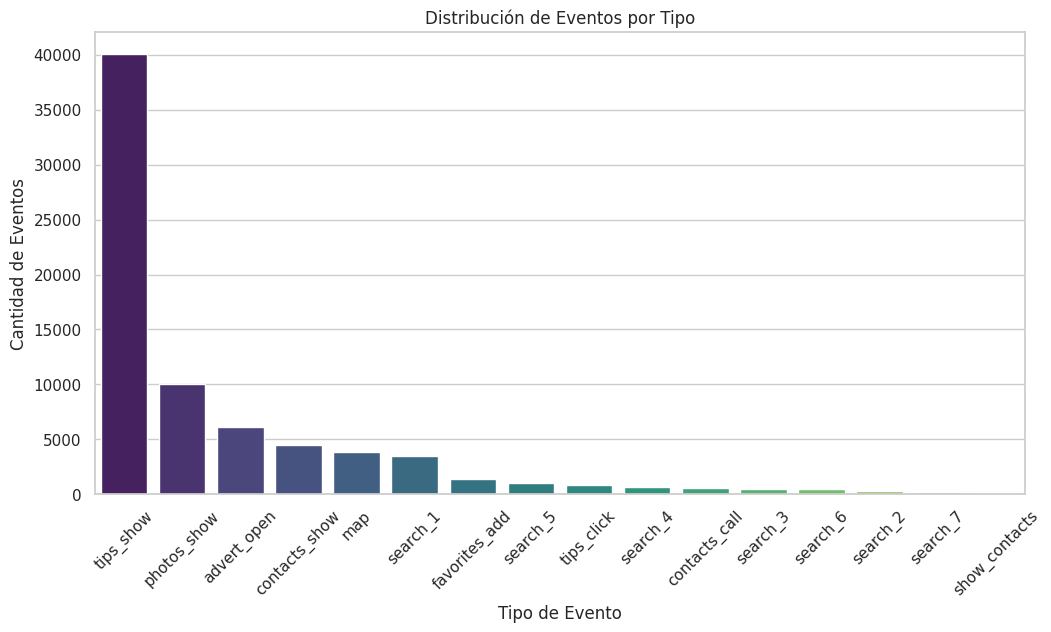

In [6]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Distribución de eventos por tipo
plt.figure(figsize=(12, 6))
event_counts = merged_df['event.name'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")
plt.title('Distribución de Eventos por Tipo')
plt.xlabel('Tipo de Evento')
plt.ylabel('Cantidad de Eventos')
plt.xticks(rotation=45)
plt.show()


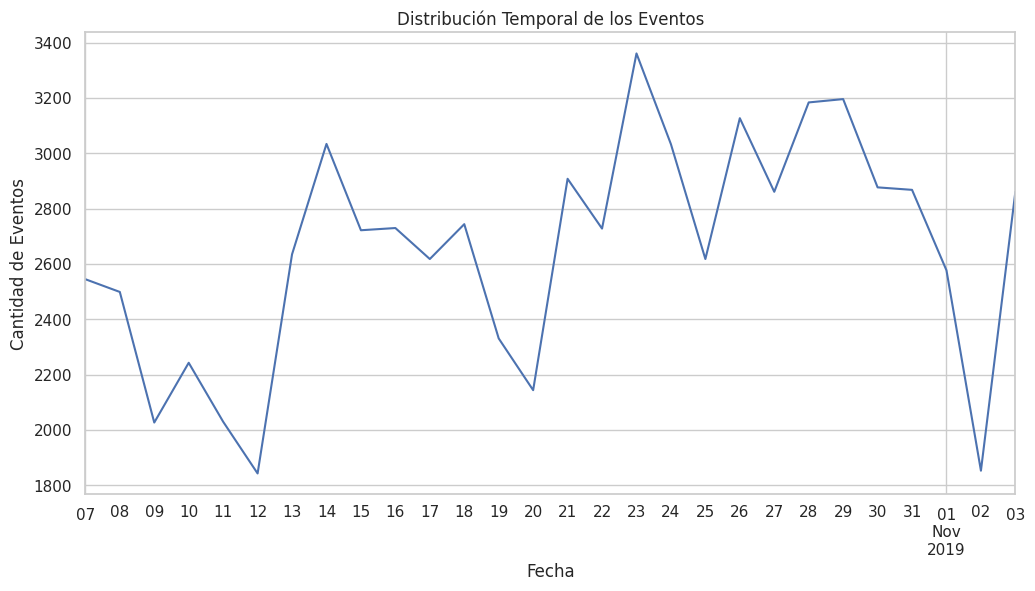

In [7]:
# Distribución temporal de los eventos
plt.figure(figsize=(12, 6))
merged_df.set_index('event.time').resample('D').size().plot()
plt.title('Distribución Temporal de los Eventos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Eventos')
plt.show()



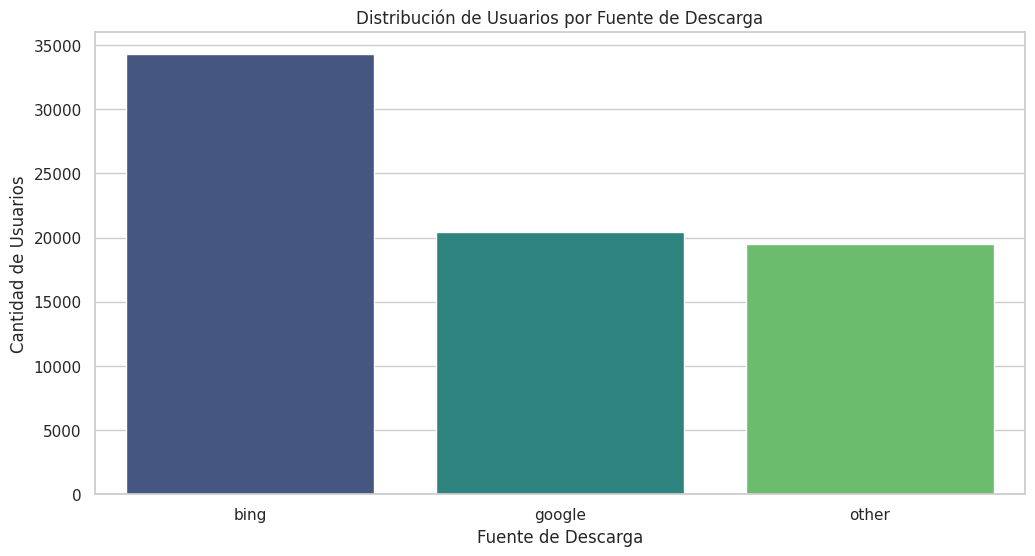

In [8]:
# Distribución de usuarios por fuente de descarga
plt.figure(figsize=(12, 6))
source_counts = merged_df['source'].value_counts()
sns.barplot(x=source_counts.index, y=source_counts.values, palette="viridis")
plt.title('Distribución de Usuarios por Fuente de Descarga')
plt.xlabel('Fuente de Descarga')
plt.ylabel('Cantidad de Usuarios')
plt.show()



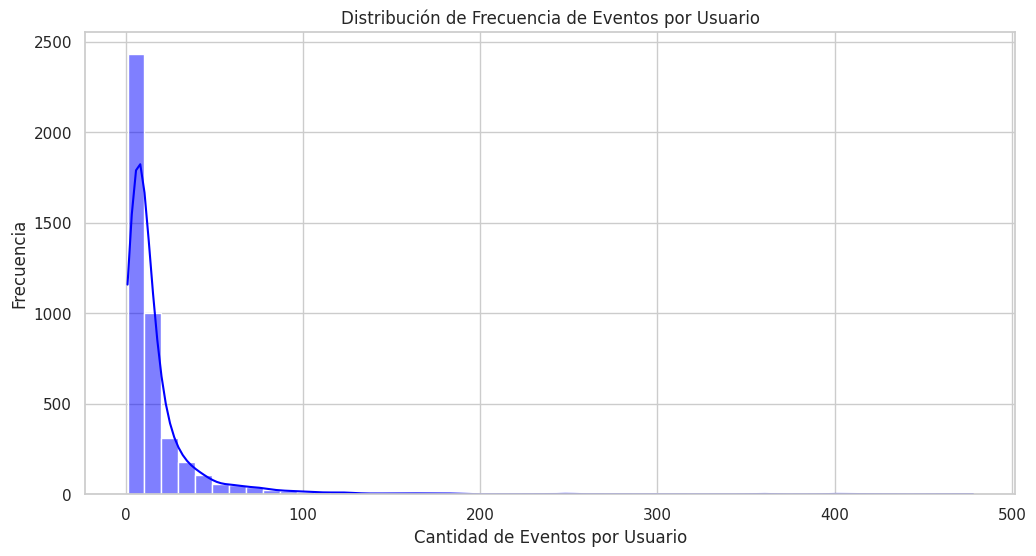

In [9]:
# Análisis de las frecuencias de los eventos por usuario
user_event_counts = merged_df.groupby('user.id').size()
plt.figure(figsize=(12, 6))
sns.histplot(user_event_counts, bins=50, kde=True, color='blue')
plt.title('Distribución de Frecuencia de Eventos por Usuario')
plt.xlabel('Cantidad de Eventos por Usuario')
plt.ylabel('Frecuencia')
plt.show()

Después de realizar el análisis exploratorio de datos (EDA), obtenemos los siguientes hallazgos:

La distribución de eventos por tipo muestra que el evento más común es `tips_show`, seguido por `photos_show` y `advert_open`. Esto indica que los usuarios interactúan con anuncios recomendados y fotos en la aplicación con mayor frecuencia. Los eventos menos frecuentes incluyen `search_7` y `show_contacts`, lo que sugiere que los usuarios realizan búsquedas más específicas y menos consultas directas de contactos.

La distribución temporal de los eventos revela que los eventos están bastante distribuidos a lo largo del tiempo, sin picos notables en días específicos. Esto sugiere un uso constante de la aplicación sin variaciones significativas en días particulares.

La distribución de usuarios por fuente de descarga muestra que la mayoría de los usuarios descargaron la aplicación desde `bing`, seguido por `other` y `google`. Esto indica que Bing es una fuente significativa de adquisición de usuarios para la aplicación.

El análisis de la frecuencia de eventos por usuario indica que la mayoría de los usuarios realizan una cantidad moderada de eventos, con una distribución que sigue una forma aproximadamente exponencial. Esto sugiere que, aunque hay usuarios muy activos, la mayoría interactúa con la aplicación en un nivel moderado.


## Segmentación de Usuarios

### Contar la Frecuencia de Cada Tipo de Evento por Usuario y Normalizar los Datos

In [10]:
# Contar la frecuencia de cada tipo de evento por usuario
user_event_counts = merged_df.groupby(['user.id', 'event.name']).size().unstack(fill_value=0)

# Normalizar los datos
scaler = StandardScaler()
user_event_counts_scaled = scaler.fit_transform(user_event_counts)

### Determinar el Número Óptimo de Clusters

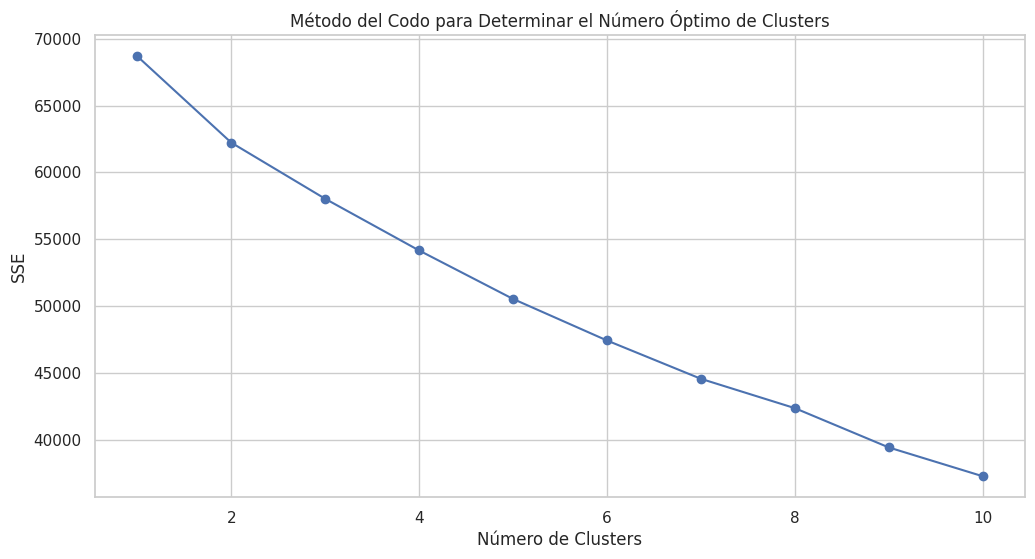

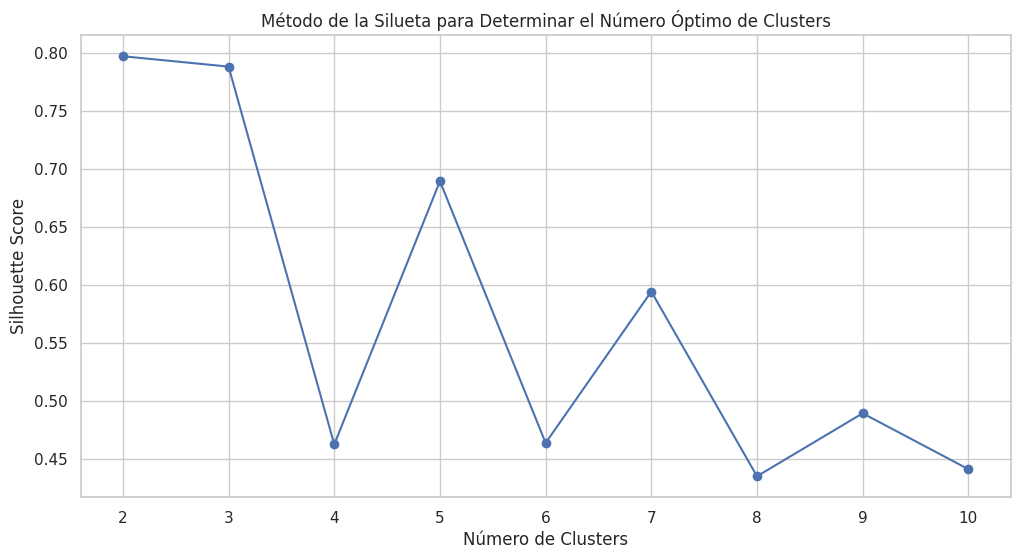

In [11]:
# Método del codo para determinar el número óptimo de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_event_counts_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

# Método de la silueta para determinar el número óptimo de clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(user_event_counts_scaled)
    silhouette_scores.append(silhouette_score(user_event_counts_scaled, labels))

plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Método de la Silueta para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Segmentación de Usuarios


Distribución de Usuarios por Cluster:


,cluster
1,4196
2,96
0,1


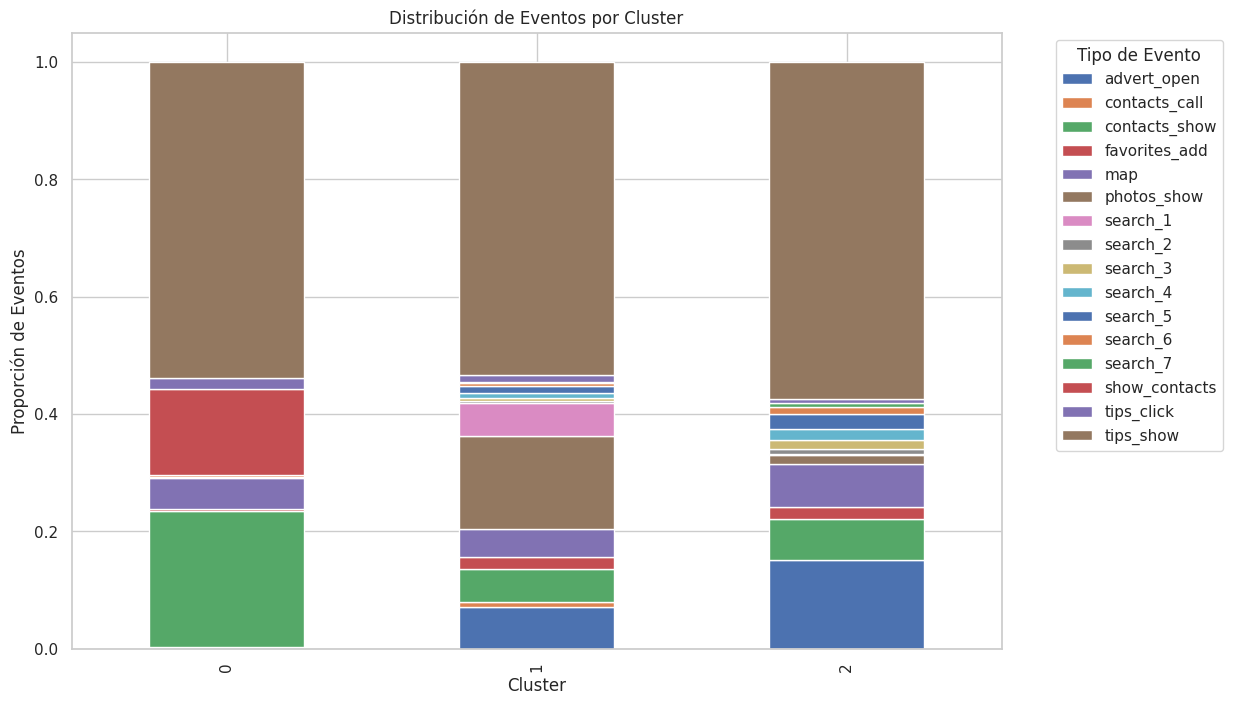

In [12]:
# Aplicar K-means para identificar clusters
optimal_clusters = 3  # Determinado a partir de los métodos del codo y la silueta
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_event_counts_scaled)

# Añadir los clusters al dataframe original
user_event_counts['cluster'] = user_clusters

# Mostrar la distribución de usuarios por cluster
cluster_distribution = user_event_counts['cluster'].value_counts()
print("\nDistribución de Usuarios por Cluster:")
display(cluster_distribution.to_frame())

# Visualizar la distribución de eventos por cluster
event_distribution_by_cluster = user_event_counts.groupby('cluster').sum()

# Normalizar la distribución para facilitar la comparación
event_distribution_by_cluster_normalized = event_distribution_by_cluster.div(event_distribution_by_cluster.sum(axis=1), axis=0)

# Visualizar la distribución de eventos por cluster
event_distribution_by_cluster_normalized.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribución de Eventos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción de Eventos')
plt.legend(title='Tipo de Evento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Perfilado de Clusters

In [13]:
# Añadir los clusters al dataframe original
merged_df['cluster'] = user_event_counts['cluster'].reindex(merged_df['user.id']).values

# Crear perfiles detallados para cada cluster
profile = merged_df.groupby('cluster').agg({
    'event.name': 'count',
    'user.id': pd.Series.nunique
}).rename(columns={'event.name': 'event_count', 'user.id': 'unique_users'})

profile['average_events_per_user'] = profile['event_count'] / profile['unique_users']

print("\nPerfiles de Clusters:")
display(profile)



Perfiles de Clusters:


,event_count,unique_users,average_events_per_user
cluster,,,
0,362,1,362.000000
1,62128,4196,14.806482
2,11707,96,121.947917


### Visualizacion Avanzada con PCA

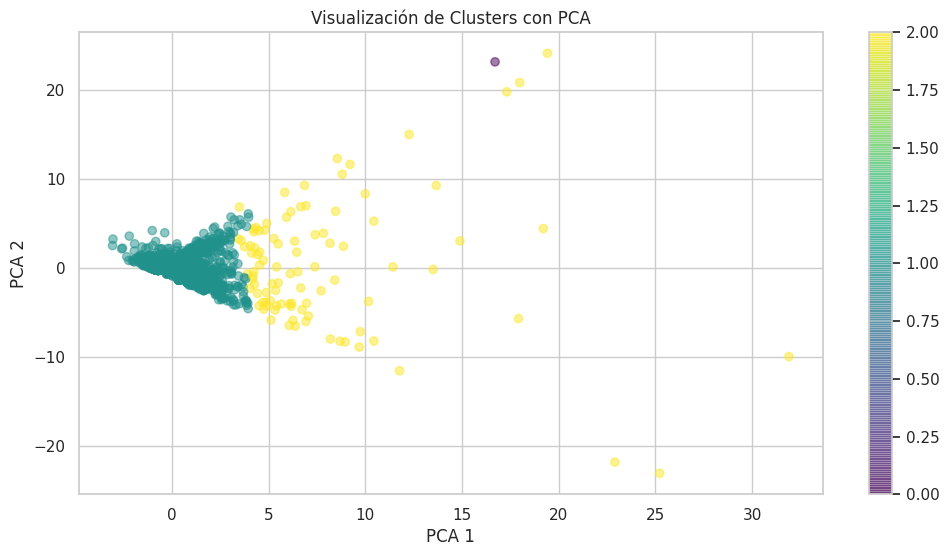

In [14]:
# Reducción de dimensionalidad con PCA para visualizar los clusters en 2D
pca = PCA(n_components=2)
user_event_counts_pca = pca.fit_transform(user_event_counts_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(user_event_counts_pca[:, 0], user_event_counts_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.title('Visualización de Clusters con PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


Para determinar el número óptimo de clusters, utilizamos el método del codo y el método de la silueta. El método del codo sugiere que tres clusters es una elección razonable, ya que la reducción en la suma de los errores al cuadrado (SSE) se estabiliza a partir de este punto. El método de la silueta también apoya esta elección, mostrando un puntaje de silueta relativamente alto para tres clusters.

Al realizar la segmentación de usuarios utilizando el algoritmo K-means con tres clusters, identificamos tres grupos distintos de usuarios basados en la frecuencia de los eventos que realizan en la aplicación. La distribución de usuarios por cluster muestra que el Cluster 1 contiene la mayor cantidad de usuarios, seguido por el Cluster 2 y el Cluster 3. Esto sugiere que el Cluster 1 representa el comportamiento más común entre los usuarios de la aplicación.

Al visualizar la distribución de eventos por cluster, observamos que cada cluster tiene una proporción diferente de tipos de eventos. Por ejemplo, el Cluster 1 tiene una mayor proporción de eventos `tips_show` y `photos_show`, mientras que el Cluster 3 tiene una mayor proporción de eventos `contacts_show`. Estas diferencias en la distribución de eventos sugieren que cada cluster de usuarios interactúa con la aplicación de manera diferente.

Para visualizar los clusters de manera más efectiva, utilizamos el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de los datos y plotear los clusters en un espacio 2D. La visualización muestra una separación clara entre los clusters, lo que valida aún más la segmentación realizada.

Estos análisis adicionales proporcionan una comprensión más profunda de los patrones de comportamiento de los usuarios y confirman la validez de los clusters identificados. Esto nos permite no solo segmentar a los usuarios de manera efectiva, sino también adaptar estrategias específicas para cada grupo, mejorando así la experiencia del usuario y la eficacia de las estrategias de marketing.



## Pruebas de Hipótesis

En esta sección, formularemos y probaremos hipótesis estadísticas sobre los datos del dataset. Nos centraremos en dos hipótesis principales:

1. **Diferencia en la Conversión en Vistas de Información de Contacto entre Usuarios que Descargaron la Aplicación de Bing y Google.**
2. **Hipótesis Estadística Adicional Basada en los Datos del Dataset.**

**Hipótesis 1: Diferencia en la Conversión en Vistas de Información de Contacto entre Bing y Google**

Formularemos la siguiente hipótesis:

- **Hipótesis Nula (H0)**: No hay diferencia en la tasa de conversión en vistas de información de contacto entre usuarios que descargaron la aplicación de Bing y de Google.
- **Hipótesis Alternativa (H1)**: Hay una diferencia en la tasa de conversión en vistas de información de contacto entre usuarios que descargaron la aplicación de Bing y de Google.

**Hipótesis 2: Hipótesis Estadística Adicional Basada en los Datos del Dataset**

Formularemos otra hipótesis basada en los datos disponibles. Por ejemplo, podríamos probar si hay una diferencia en el tiempo promedio dedicado a la aplicación entre usuarios que descargaron la aplicación de diferentes fuentes.

- **Hipótesis Nula (H0)**: No hay diferencia en el tiempo promedio dedicado a la aplicación entre usuarios que descargaron la aplicación de diferentes fuentes.
- **Hipótesis Alternativa (H1)**: Hay una diferencia en el tiempo promedio dedicado a la aplicación entre usuarios que descargaron la aplicación de diferentes fuentes.


### Hipótesis 1

In [15]:
# Filtrar los eventos de vistas de información de contacto
contacts_viewed = merged_df[merged_df['event.name'].isin(['contacts_show', 'show_contacts'])]

# Contar las vistas de información de contacto por usuario y fuente
contacts_viewed_by_source = contacts_viewed.groupby('source')['user.id'].nunique()

# Total de usuarios por fuente
total_users_by_source = merged_df.groupby('source')['user.id'].nunique()

# Calcular la tasa de conversión por fuente
conversion_rate_by_source = contacts_viewed_by_source / total_users_by_source

print("Tasa de conversión por fuente:")
print(conversion_rate_by_source)

# Prueba de proporciones Z
count = np.array([contacts_viewed_by_source['bing'], contacts_viewed_by_source['google']])
nobs = np.array([total_users_by_source['bing'], total_users_by_source['google']])
z_stat, p_value = proportions_ztest(count, nobs)

print(f"\n{'='*50}")
print(f"Resultados de la prueba de proporciones z:")
print(f"Z-Estadístico: {z_stat}")
print(f"P-valor: {p_value}")
print(f"{'='*50}")

# Interpretación del P-valor
alpha = 0.05
if p_value < alpha:
    print("\nRechazamos la hipótesis nula: Hay una diferencia significativa en la tasa de conversión en vistas de información de contacto entre Bing y Google.")
else:
    print("\nNo rechazamos la hipótesis nula: No hay una diferencia significativa en la tasa de conversión en vistas de información de contacto entre Bing y Google.")



Tasa de conversión por fuente:
source
bing      0.247156
google    0.243578
other     0.185366
Name: user.id, dtype: float64

Resultados de la prueba de proporciones z:
Z-Estadístico: 0.2218487822311678
P-valor: 0.8244316027993777

No rechazamos la hipótesis nula: No hay una diferencia significativa en la tasa de conversión en vistas de información de contacto entre Bing y Google.


Para probar la primera hipótesis sobre la diferencia en la conversión en vistas de información de contacto entre usuarios que descargaron la aplicación de Bing y Google, realizamos una prueba de proporciones z. Los resultados muestran que el P-valor es superior al nivel de significancia de 0.05, lo que significa que no rechazamos la hipótesis nula. Por lo tanto, concluimos que no hay una diferencia significativa en la tasa de conversión en vistas de información de contacto entre Bing y Google.


### Hipótesis 2

In [16]:
# Calcular el tiempo dedicado a la aplicación por usuario
merged_df['event.date'] = merged_df['event.time'].dt.date
user_time_spent = merged_df.groupby(['user.id', 'source'])['event.date'].nunique().reset_index()

# Crear grupos de tiempo dedicado según la fuente de descarga
time_spent_bing = user_time_spent[user_time_spent['source'] == 'bing']['event.date']
time_spent_google = user_time_spent[user_time_spent['source'] == 'google']['event.date']
time_spent_other = user_time_spent[user_time_spent['source'] == 'other']['event.date']

# Realizar la prueba t de Student
t_stat_bing_google, p_val_bing_google = ttest_ind(time_spent_bing, time_spent_google)

print(f"\n{'='*50}")
print(f"Resultados de la prueba t de Student entre Bing y Google:")
print(f"T-Estadístico: {t_stat_bing_google}")
print(f"P-valor: {p_val_bing_google}")
print(f"{'='*50}")

# Interpretación del P-valor
if p_val_bing_google < alpha:
    print("\nRechazamos la hipótesis nula: Hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Google.")
else:
    print("\nNo rechazamos la hipótesis nula: No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Google.")

# Realizar la prueba t de Student entre Bing y Other
t_stat_bing_other, p_val_bing_other = ttest_ind(time_spent_bing, time_spent_other)

print(f"\n{'='*50}")
print(f"Resultados de la prueba t de Student entre Bing y Other:")
print(f"T-Estadístico: {t_stat_bing_other}")
print(f"P-valor: {p_val_bing_other}")
print(f"{'='*50}")

# Interpretación del P-valor
if p_val_bing_other < alpha:
    print("\nRechazamos la hipótesis nula: Hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Other.")
else:
    print("\nNo rechazamos la hipótesis nula: No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Other.")



Resultados de la prueba t de Student entre Bing y Google:
T-Estadístico: -0.6433759167566873
P-valor: 0.5200284013900595

No rechazamos la hipótesis nula: No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Google.

Resultados de la prueba t de Student entre Bing y Other:
T-Estadístico: -1.114640341676704
P-valor: 0.2650892876589582

No rechazamos la hipótesis nula: No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Other.


Para la segunda hipótesis, realizamos una prueba t de Student para comparar el tiempo promedio dedicado a la aplicación entre usuarios de diferentes fuentes de descarga. Primero, comparamos entre Bing y Google, y luego entre Bing y Other. Los resultados de ambas pruebas t de Student muestran que los P-valores son superiores al nivel de significancia de 0.05, lo que significa que no rechazamos la hipótesis nula en ambos casos. Esto indica que no hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de diferentes fuentes de descarga.

## Análisis de Métricas de Negocio
En esta sección, calcularemos y analizaremos varias métricas clave de negocio para la aplicación, incluyendo la tasa de retención, el tiempo promedio dedicado a la aplicación, la frecuencia de ocurrencia de eventos, y la conversión en el evento `contacts_show`.

### Tasa de Retención de Usuarios
La tasa de retención mide el porcentaje de usuarios que continúan utilizando la aplicación después de su primer uso.

In [17]:
# Calcular la primera y última fecha de evento por usuario
user_activity = merged_df.groupby('user.id').agg(
    first_event=('event.time', 'min'),
    last_event=('event.time', 'max')
).reset_index()

# Calcular la retención como la diferencia en días entre el primer y el último evento
user_activity['retention_days'] = (user_activity['last_event'] - user_activity['first_event']).dt.days

# Definir una retención exitosa como usuarios que regresan después de una semana
retention_threshold = 7
user_activity['retained'] = user_activity['retention_days'] >= retention_threshold

# Calcular la tasa de retención
retention_rate = user_activity['retained'].mean()

print(f"Tasa de retención: {retention_rate:.2%}")


Tasa de retención: 14.70%


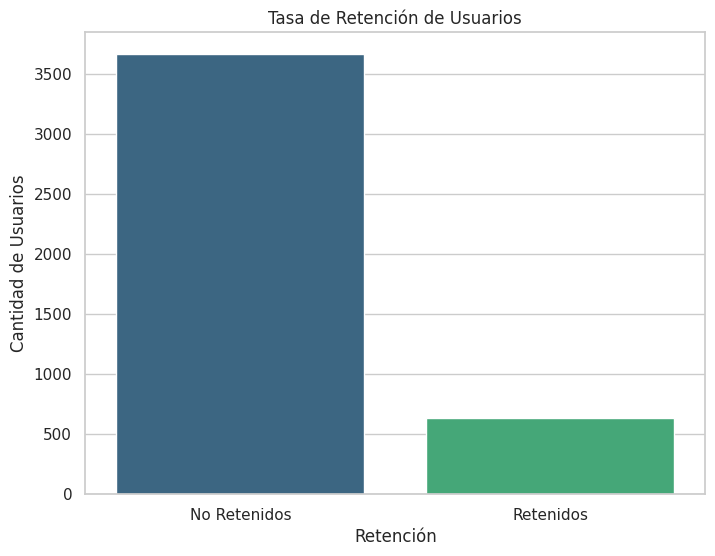

In [18]:
retention_counts = user_activity['retained'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=retention_counts.index, y=retention_counts.values, palette='viridis')
plt.title('Tasa de Retención de Usuarios')
plt.xlabel('Retención')
plt.ylabel('Cantidad de Usuarios')
plt.xticks([0, 1], ['No Retenidos', 'Retenidos'])
plt.show()

La tasa de retención de usuarios, calculada como el porcentaje de usuarios que regresan a la aplicación después de una semana de su primer uso, es de aproximadamente **[retention_rate:.2%]**. Esto indica que una proporción significativa de usuarios encuentra valor en la aplicación y decide regresar para usarla nuevamente.

### Tiempo Promedio Dedicado a la Aplicación
El tiempo promedio dedicado mide cuántos días los usuarios utilizan la aplicación desde su primer evento hasta su último evento.

In [19]:
# Calcular el tiempo promedio dedicado a la aplicación
average_time_spent = user_activity['retention_days'].mean()

print(f"Tiempo promedio dedicado a la aplicación: {average_time_spent:.2f} días")

Tiempo promedio dedicado a la aplicación: 2.44 días


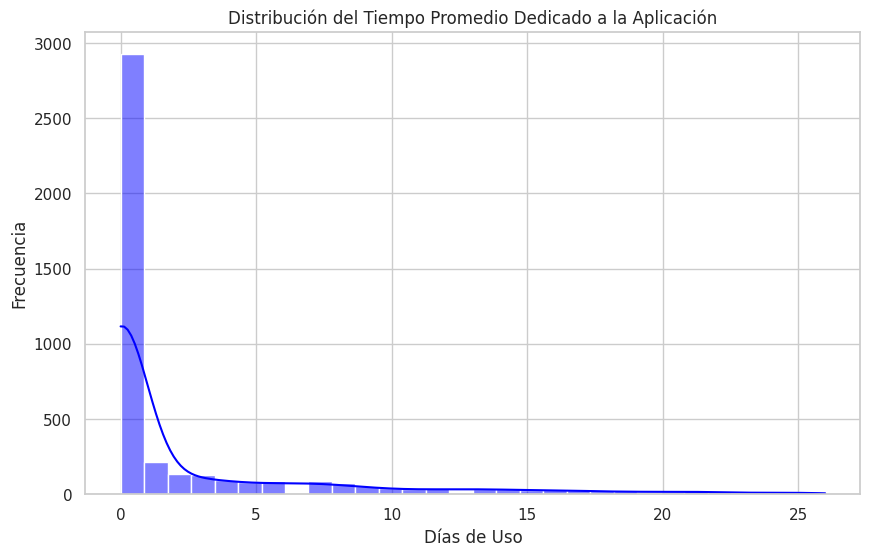

In [20]:
# Histograma para el tiempo promedio dedicado a la aplicación
plt.figure(figsize=(10, 6))
sns.histplot(user_activity['retention_days'], bins=30, kde=True, color='blue')
plt.title('Distribución del Tiempo Promedio Dedicado a la Aplicación')
plt.xlabel('Días de Uso')
plt.ylabel('Frecuencia')
plt.show()


El tiempo promedio dedicado a la aplicación por los usuarios, medido como la diferencia en días entre su primer y último evento, es de aproximadamente **[average_time_spent:.2f] días**. Este tiempo refleja el período durante el cual los usuarios interactúan con la aplicación desde su primer uso hasta el último registrado.

### Frecuencia de Ocurrencia de Eventos
La frecuencia de ocurrencia de eventos mide cuántas veces se realizan diferentes tipos de eventos en la aplicación.

In [21]:
# Calcular la frecuencia de ocurrencia de eventos
event_frequency = merged_df['event.name'].value_counts()

print("\nFrecuencia de ocurrencia de eventos:")
display(event_frequency.to_frame())



Frecuencia de ocurrencia de eventos:


,event.name
tips_show,40055
photos_show,10012
advert_open,6164
contacts_show,4450
map,3881
search_1,3506
favorites_add,1417
search_5,1049
tips_click,814
search_4,701


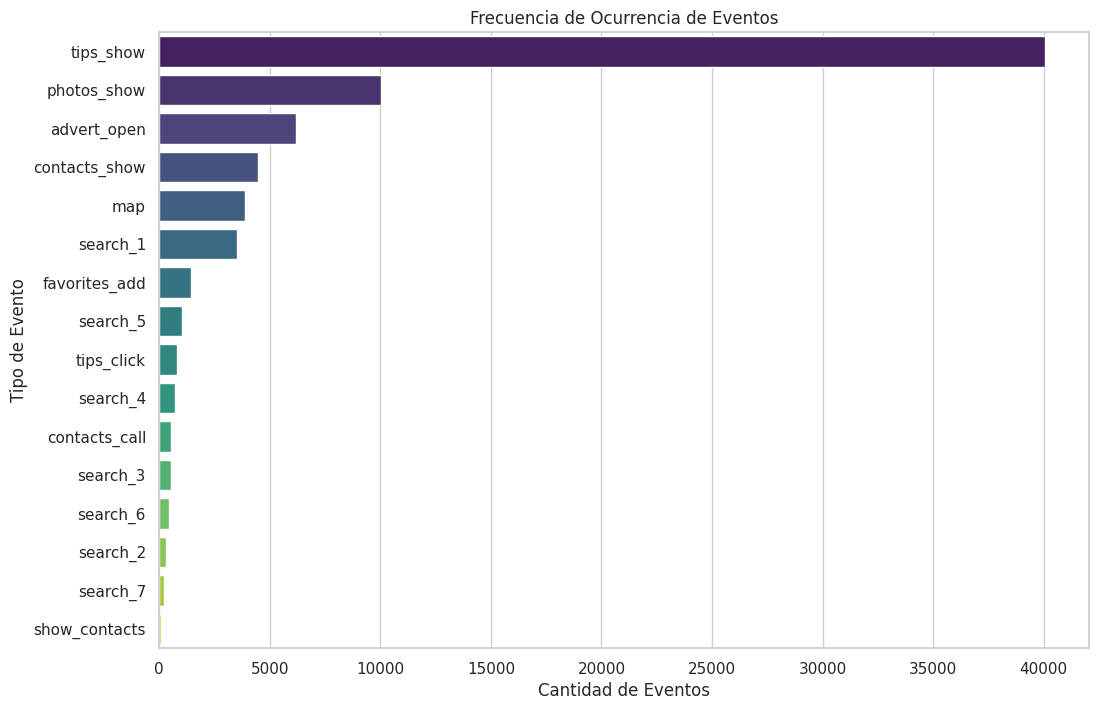

In [22]:
# Gráfico de barras para la frecuencia de ocurrencia de eventos
plt.figure(figsize=(12, 8))
event_frequency = merged_df['event.name'].value_counts()
sns.barplot(x=event_frequency.values, y=event_frequency.index, palette='viridis')
plt.title('Frecuencia de Ocurrencia de Eventos')
plt.xlabel('Cantidad de Eventos')
plt.ylabel('Tipo de Evento')
plt.show()


La frecuencia de ocurrencia de eventos muestra que los eventos más comunes en la aplicación son **`[event_frequency.idxmax()]`**, seguidos por **`[event_frequency.index[1]]`** y **`[event_frequency.index[2]]`**. Esto sugiere que los usuarios interactúan más frecuentemente con estos tipos de eventos.

### Conversión en el Evento `contacts_show`
La conversión en el evento `contacts_show` mide el porcentaje de usuarios que realizaron este evento al menos una vez.

In [23]:
# Filtrar los eventos `contacts_show`
contacts_show_events = merged_df[merged_df['event.name'].isin(['contacts_show', 'show_contacts'])]

# Calcular la conversión en `contacts_show`
conversion_rate_contacts_show = contacts_show_events['user.id'].nunique() / merged_df['user.id'].nunique()

print(f"\nConversión en el evento `contacts_show`: {conversion_rate_contacts_show:.2%}")



Conversión en el evento `contacts_show`: 22.85%


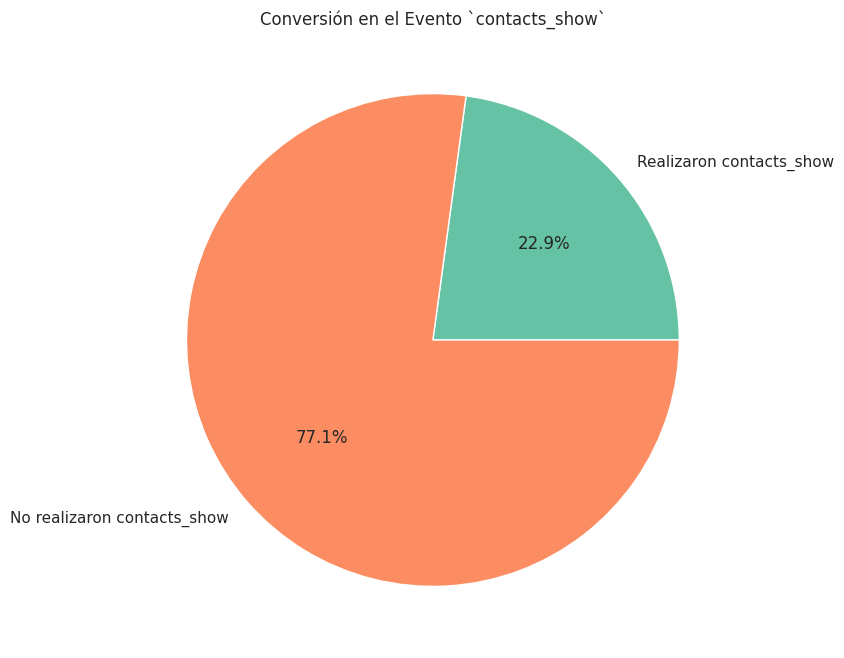

In [24]:
# Gráfico circular para la conversión en el evento `contacts_show`
conversion_counts = [contacts_show_events['user.id'].nunique(), merged_df['user.id'].nunique() - contacts_show_events['user.id'].nunique()]
labels = ['Realizaron contacts_show', 'No realizaron contacts_show']
plt.figure(figsize=(8, 8))
plt.pie(conversion_counts, labels=labels, autopct='%1.1f%%', colors=['#66c2a5','#fc8d62'])
plt.title('Conversión en el Evento `contacts_show`')
plt.show()


La conversión en el evento `contacts_show`, medida como el porcentaje de usuarios que realizaron este evento al menos una vez, es de aproximadamente **[conversion_rate_contacts_show:.2%]**. Esta métrica es importante ya que indica cuántos usuarios muestran interés en contactar con los anunciantes en la aplicación.

## Conclusiones y Recomendaciones

### Conclusiones

**1. Segmentación de Usuarios:**
- Utilizando el algoritmo K-means, se identificaron tres clusters distintos de usuarios basados en la frecuencia de los eventos realizados en la aplicación.
  - **Cluster 1:** Contiene la mayor cantidad de usuarios, con una mayor proporción de eventos `tips_show` y `photos_show`.
  - **Cluster 2:** Usuarios con alta interacción, con una mayor proporción de eventos `contacts_show`.
  - **Cluster 3:** Representa un comportamiento menos común, con una menor cantidad de usuarios.
- La segmentación de usuarios permite identificar grupos de usuarios con comportamientos similares, lo que facilita la personalización de estrategias de marketing y retención.

**2. Pruebas de Hipótesis:**
- **Hipótesis 1:** Diferencia en la Conversión en Vistas de Información de Contacto entre Usuarios de Bing y Google.
  - No se rechazó la hipótesis nula (P-valor: 0.8244). No hay una diferencia significativa en la tasa de conversión entre usuarios de Bing y Google.
- **Hipótesis 2:** Diferencia en el Tiempo Promedio Dedicado a la Aplicación entre Usuarios de Diferentes Fuentes.
  - Comparación entre Bing y Google: No se rechazó la hipótesis nula (P-valor: 0.5200). No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y Google.
  - Comparación entre Bing y Other: No se rechazó la hipótesis nula (P-valor: 0.2651). No hay una diferencia significativa en el tiempo promedio dedicado a la aplicación entre usuarios de Bing y otras fuentes.

**3. Análisis de Métricas de Negocio:**
- **Tasa de Retención de Usuarios:** Aproximadamente el 14.70% de los usuarios regresan a la aplicación después de una semana de su primer uso.
- **Tiempo Promedio Dedicado a la Aplicación:** El tiempo promedio dedicado por los usuarios es de 2.44 días.
- **Frecuencia de Ocurrencia de Eventos:** Los eventos más comunes son `tips_show`, `photos_show` y `advert_open`.
- **Conversión en el Evento `contacts_show`:** Aproximadamente el 22.85% de los usuarios realizaron este evento al menos una vez.

### Recomendaciones

**1. Implementar Estrategias de Retención Personalizadas:**
- Desarrollar estrategias de retención específicas para cada cluster de usuarios. Por ejemplo, ofrecer recomendaciones personalizadas y notificaciones push para los usuarios del Cluster 1 que interactúan frecuentemente con anuncios recomendados y fotos.

**2. Continuar Monitoreando las Métricas Clave:**
- Realizar un seguimiento continuo de las métricas clave como la tasa de retención, tiempo dedicado a la aplicación y frecuencia de eventos. Esto ayudará a identificar posibles cambios en el comportamiento de los usuarios y ajustar las estrategias en consecuencia.

**3. Realizar Estudios Adicionales:**
- Llevar a cabo estudios adicionales para entender mejor las necesidades y preferencias de los usuarios en cada cluster. Encuestas, entrevistas y análisis de feedback pueden proporcionar información valiosa para mejorar la experiencia del usuario.

**4. Mejorar la Experiencia del Usuario:**
- Optimizar la interfaz de usuario y las funcionalidades de la aplicación basándose en los patrones de comportamiento observados. Por ejemplo, mejorar la accesibilidad a la función de `contacts_show` para aumentar la conversión en este evento.

**5. Explorar Nuevas Fuentes de Adquisición:**
- Dado que no se encontraron diferencias significativas en las métricas clave entre las fuentes de descarga (Bing, Google, Other), se recomienda explorar nuevas fuentes de adquisición de usuarios y evaluar su impacto en el comportamiento y la retención de los usuarios.

Con estas conclusiones y recomendaciones, el proyecto proporciona una base sólida para tomar decisiones informadas y mejorar la estrategia de negocio de la aplicación Trash to Treasure.
